# Finite Difference with Python

## The 1D Wave

This example of FDTD in Python will consider the 1D Wave Equation $$\ddot{u} = c^2 u^{\prime\prime}$$


### Assumptions

This tutorials assumes that you are already familiar with the 1D wave equation and its derivation. It also assumes that you have a grasp of the Finite Difference operators and the derivation of the Finite Difference Scheme for the 1D Wave.

If you are not familiar with the above or need a refresher follow the links below

- [1D Wave PDE]()
- [FDTD Operators]()
- [1D Wave FDTD Scheme]()


### Overview

As a reminder, the finite difference scheme for the 1D wave we are trying to implement is:

\begin{equation*}
\underbrace{(1+\sigma k)(I)}_{A}u^{n+1}  = \underbrace{(\lambda^2D_{xx} + 2I}_{B})u^{n}  -\underbrace{(1-\sigma k)(I)}_{C} u^{n-1} 
\label{eq:scheme} \tag{1}
\end{equation*}

\begin{equation*}
\lambda = \frac{ck}{h}; \quad \sigma = \frac{6\log(10)}{T_{60}}
\label{eq:courant} \tag{2}
\end{equation*}

\begin{align}
D_{xx} & = \begin{bmatrix}
               -2 & 1 & &   \\[0.3em]
               1 & -2 & 1 & \\[0.3em]
                  & \ddots & \ddots & \ddots  \\[0.3em]
                  & & 1 & -2
             \end{bmatrix}
             \label{eq:boundmat} \tag{3}
\end{align}



Any Finite Difference scheme you need to programnme can likely be split into the following sections

1. Import Libraries
1. Coefficients
    - Defined
    - Derived
      - Motion
      - Loss
2. Build Coefficient Matrices
    - A, B, C
    - Boundary Conditions
3. Set up time-state Matrices
4. Set initial conditions  
    - Generate a raised cosine
5. Define time-step state update methods

- Appendix A: Scheme class in full.



### Import Libraries

In [1]:
import numpy as np
from numpy import pi,log,sqrt,floor
from scipy import sparse

#### Simulation Parameters

In [2]:
SR = 44100.0;    # sample rate (Hz)
Tf = 0.1;        # duration of simulation (s)
xi = 0.8;        # coordinate of excitation (normalised, 0 - 1)
xo = 0.1;        # coordinate of output (normalised, 0 - 1)

### Coefficients
#### Defined

In [3]:
f0  = 440.0;   # fundamental frequency (Hz)
r   = 1.27e-4; # string radius (m)
L   = 1.0;     # length (m)
rho = 7850;    # density (kg/m^3) of steel
T60 = 1.0;     # T60 (s)
bc  = 1;        # boundary condition 1: pivot; 2: clamped

#### Derived

In [4]:
T = rho * pi * ((f0 * 2 * L) ** 2) * (r**2); # Tension in Newtons
A = pi * (r ** 2.0);         # string cross-sectional area
I = 0.25 * pi * (r ** 4.0);  # string moment of intertia
c = sqrt( T / (rho * A));    # wave speed
sig = 6.0 * log(10.0) / T60; # loss parameter

#### Grid

In [5]:
k    = 1.0 / SR; # time step
hmin = c * k; # stability condition 
hmin = sqrt(0.5 * (c**2.*k**2 + sqrt(c ** 4 * k**4)));    # minimal grid spacing

N = int(floor(L / hmin)); # number of segments (N+1 is number of grid points)
h = L / N;                # adjusted grid spacing

lamb = c * k / h;           # Courant number
Nf   = int(floor(SR * Tf)); # number of time steps

#### Input / Ouput

In [6]:
li = int(floor(xi * N));         # grid index of excitation
lo = int(floor(xo * N));         # grid index of output

### Time States

Allocate the correct amount of memory using [`np.zeros()`](https://numpy.org/doc/stable/reference/generated/numpy.zeros.html)

In [7]:
u0  = np.zeros(N)
u1  = np.zeros(N)
u2  = np.zeros(N)

out = np.zeros(Nf)

#### Initial Condition

In [8]:
u1[li] = 1.0;

### Matrices

In [9]:
Dxx = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(N, N)).tocsc()

A = 1.0 / (1.0 + (k * sig)) # inverted
B = A * ((lamb ** 2) * Dxx + (2 * sparse.eye(N)));
C = A * ((-1.0 + (k * sig))  * sparse.eye(N));

print(C.todense())

[[-0.99937364  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.99937364  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         -0.99937364 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.99937364  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.99937364
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.99937364]]


#### Stencil Shape

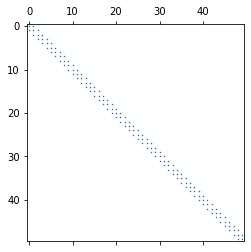

In [10]:
import matplotlib.pyplot as plt

plt.spy(B, markersize=0.5)

plt.show()

print()

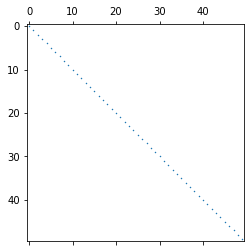

In [11]:
import matplotlib.pyplot as plt

plt.spy(C, markersize=0.5)

plt.show()

#### Main Time Loop

In [12]:
for n in range(Nf):
    u0 = B * u1 + C * u2
    u2, u1, u0 = u1, u0, u2 # state swap
    out[n] = u0[lo]

### Audio Output

In [13]:
import IPython.display as ipd

ipd.Audio(data=out, rate=SR)